Setting up environment

In [0]:
%pip install numpy==1.24.4

Python interpreter will be restarted.
  Attempting uninstall: numpy
    Found existing installation: numpy 1.21.5
    Not uninstalling numpy at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-192cbe8e-77e6-4f58-a9cb-49374cafa8b4
    Can't uninstall 'numpy'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
scipy 1.7.3 requires numpy<1.23.0,>=1.16.5, but you have numpy 1.24.4 which is incompatible.
Python interpreter will be restarted.


In [0]:
%pip install xarray==2023.12.0 --no-deps





Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
%pip install s3fs==2023.6.0

Python interpreter will be restarted.
  Attempting uninstall: botocore
    Found existing installation: botocore 1.24.32
    Not uninstalling botocore at /databricks/python3/lib/python3.9/site-packages, outside environment /local_disk0/.ephemeral_nfs/envs/pythonEnv-192cbe8e-77e6-4f58-a9cb-49374cafa8b4
    Can't uninstall 'botocore'. No files were found to uninstall.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
boto3 1.21.32 requires botocore<1.25.0,>=1.24.32, but you have botocore 1.31.17 which is incompatible.
Python interpreter will be restarted.


In [0]:
%pip install h5netcdf

Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
%pip install cftime


Python interpreter will be restarted.
Python interpreter will be restarted.


In [0]:
import pandas as pd
import time
import os

In [0]:
import xarray as xr
import s3fs
import numpy as np
from datetime import datetime, timedelta

print(np.__version__)
print(xr.__version__)


1.24.4
2023.12.0


Using pyspark to read in and merge all the file monthly files we saved that are filterd by latitude and longitude. Also adding a column called date. I noticed that the files seemed to be missing dates. They were avaiable in the original NetCDF files, but I lost the dates somewhere in the process. I think the time column contained the time and the date in the original file, but when I filtered by lat and lon, I did not decode the time in order to save on time.

In [0]:
from pyspark.sql.functions import input_file_name, regexp_extract

# Load all files
df = spark.read.parquet("/dbfs/2024*.parquet")

# Extract date from the filename using regex (e.g., 20240101)
merged_df = df.withColumn(
    "date",
    regexp_extract(input_file_name(), r"(\d{8})\.parquet", 1)
)


In [0]:
# checking to make sure all the dates are in the merged file
merged_df.select("date").distinct().show(31)

+--------+
|    date|
+--------+
|20240103|
|20240108|
|20240116|
|20240109|
|20240111|
|20240110|
|20240106|
|20240118|
|20240112|
|20240114|
|20240107|
|20240113|
|20240115|
|20240119|
|20240117|
|20240122|
|20240105|
|20240124|
|20240123|
|20240130|
|20240128|
|20240125|
|20240126|
|20240121|
|20240101|
|20240120|
|20240104|
|20240127|
|20240102|
|20240129|
|20240131|
+--------+



In [0]:
# pull in one file to compare size to the merged dataset
df_20240101 = spark.read.parquet("/dbfs/20240101.parquet")

In [0]:
# compare sizes of datasets to make sure the merged dataset seems to include all the data from the 31 files.
print(f'single data file row count: {df_20240101.count()}')
print(f'single data file column count: {len(df_20240101.columns)}')

print(f'single data file row count: {merged_df.count()}')
print(f'single data file column count: {len(merged_df.columns)}')

single data file row count: 3588
single data file column count: 153
single data file row count: 111228
single data file column count: 154


In [0]:
from pyspark.sql.functions import avg, round, col, min

## Questions to Answer from the Dataset.

1. What days, on average where warmest and which were coldest in January for our bounded dataset that includes Minnesota and the surrounding area?

In [0]:
# Temperature is in kelvin, would like to see it in Fahrenheit
# Add a new column for temperature in Fahrenheit
# two meter temperature: tmp2m
# temperature: tmp
merged_df = merged_df.withColumn(
    "tmp2m_fahr",
    (col("tmp2m") - 273.15) * 9/5 + 32
)

# Group by date and calculate average temperature
daily_avg_temp = merged_df.groupBy("date").agg(
    round(avg(col("tmp2m_fahr")), 2).alias("avg_temp_f"),
    round(avg(col("tmp2m")), 2).alias("avg_temp_k")
)

# Order from warmest to coldest
ranked_days_temp = daily_avg_temp.orderBy("avg_temp_f", ascending=False).show(31)

daily_avg_temp.display()


+--------+----------+----------+
|    date|avg_temp_f|avg_temp_k|
+--------+----------+----------+
|20240131|     31.63|    272.94|
|20240130|     29.21|     271.6|
|20240126|     28.76|    271.35|
|20240125|     28.39|    271.14|
|20240124|     28.18|    271.03|
|20240129|      28.0|    270.93|
|20240102|     26.25|    269.96|
|20240106|     25.31|    269.43|
|20240128|     24.88|    269.19|
|20240127|     24.08|    268.75|
|20240103|     20.53|    266.78|
|20240105|     19.14|    266.01|
|20240123|     18.45|    265.62|
|20240101|     18.45|    265.62|
|20240109|     16.07|     264.3|
|20240110|     15.79|    264.15|
|20240122|     15.11|    263.77|
|20240104|     14.14|    263.23|
|20240108|     14.05|    263.18|
|20240107|     12.47|     262.3|
|20240111|     11.19|    261.59|
|20240121|      7.91|    259.76|
|20240112|       4.0|     257.6|
|20240113|      1.45|    256.18|
|20240117|     -3.07|    253.67|
|20240119|     -3.84|    253.24|
|20240118|     -4.61|    252.81|
|20240116|

date,avg_temp_f,avg_temp_k
20240103,20.53,266.78
20240108,14.05,263.18
20240116,-4.99,252.6
20240109,16.07,264.3
20240111,11.19,261.59
20240110,15.79,264.15
20240106,25.31,269.43
20240118,-4.61,252.81
20240112,4.0,257.6
20240114,-7.94,250.96


Databricks visualization. Run in Databricks to view.

2. What are the locations with the highest surface snow depth (m)?

In [0]:
# NOTE: longitude measurement is in 360 degrees to get a measurement that google maps
# will recognize, take the lon measure and subtract 360.
from pyspark.sql.functions import max
highest_snow = merged_df.groupBy("lat","lon").agg(max("snod").alias("max_snow_depth_in_m"))

Top_50_highest_snow = highest_snow.orderBy("max_snow_depth_in_m", ascending=False).limit(50)

Top_50_highest_snow.display()

lat,lon,max_snow_depth_in_m
46.68401891076719,270.3515625,0.68954295
46.68401891076719,270.46875,0.61814845
46.80116826299966,270.3515625,0.61790466
46.68401891076719,270.234375,0.61224204
46.80116826299966,270.234375,0.5744424
46.44972020613126,269.53125,0.55355924
46.56686955847757,270.0,0.55243963
46.44972020613126,269.765625,0.54841727
46.44972020613126,269.6484375,0.54841727
46.44972020613126,269.8828125,0.5324939


Databricks visualization. Run in Databricks to view.

3. What are the locations with the lowest temperatures (F)?

In [0]:
from pyspark.sql.functions import max
highest_snow = merged_df.groupBy("lat","lon").agg(min("tmp2m_fahr").alias("coldest_temps"))

Top_50_lowest_temp = highest_snow.orderBy("coldest_temps", ascending=True).limit(50)

Top_50_lowest_temp.display()

lat,lon,coldest_temps
43.98958379456332,268.9453125,-27.967015380859337
43.98958379456332,268.828125,-27.949849243164024
44.1067331479976,268.9453125,-27.77634765624996
43.98958379456332,269.0625,-27.480760498046834
44.1067331479976,268.828125,-27.101649780273398
43.87243444108175,268.828125,-26.702296752929648
43.52098638035698,268.9453125,-26.368559570312456
43.87243444108175,268.9453125,-26.209450073242145
43.87243444108175,268.7109375,-25.883265991210898
43.98958379456332,268.7109375,-25.832646484374962


Databricks visualization. Run in Databricks to view.

4. What are the locations with the highest wind speeds (m/s)?

In [0]:

from pyspark.sql.functions import max
highest_snow = merged_df.groupBy("lat","lon").agg(max("ugrd10m").alias("highest_10m_wind"))

Top_50_highest_wind = highest_snow.orderBy("highest_10m_wind", ascending=False).limit(50)

Top_50_highest_wind.display()

lat,lon,highest_10m_wind
46.91831761517448,270.46875,13.782442
46.80116826299966,270.0,13.486903
46.91831761517448,270.3515625,13.485025
46.91831761517448,270.234375,13.371787
46.80116826299966,269.8828125,13.345768
46.91831761517448,270.1171875,13.256703
46.80116826299966,270.1171875,13.102294
46.91831761517448,270.0,12.973577
47.035466967291164,270.46875,12.923799
46.91831761517448,269.8828125,12.902269


Databricks visualization. Run in Databricks to view.

5. What are the locations with the highest precipitation (kg/m**2)?

In [0]:
from pyspark.sql.functions import max
highest_snow = merged_df.groupBy("lat","lon").agg(max("tprcp").alias("highest_precip"))

Top_50_highest_precip = highest_snow.orderBy("highest_precip", ascending=False).limit(50)

Top_50_highest_precip.display()

lat,lon,highest_precip
43.75528508755325,264.2578125,1.0216333E-4
43.63813573397821,264.2578125,9.724074E-5
43.63813573397821,264.140625,9.489049E-5
43.75528508755325,264.0234375,8.948124E-5
43.75528508755325,264.140625,8.948124E-5
43.75528508755325,264.375,8.642263E-5
43.87243444108175,264.2578125,8.505652E-5
43.63813573397821,269.53125,8.469539E-5
43.52098638035698,264.140625,8.403179E-5
43.52098638035698,263.4375,8.352284E-5


Databricks visualization. Run in Databricks to view.

6. I'd like to look at the locations with the highest surface roughness (M). 
- I beleive this is a measure for water roughness, but it looks like they have the data for land too.

In [0]:

from pyspark.sql.functions import max
highest_snow = merged_df.groupBy("lat","lon").agg(max("sfcr").alias("rough_surface"))

Top_50_roughest_surface = highest_snow.orderBy("rough_surface", ascending=False).limit(50)

Top_50_roughest_surface.display()

lat,lon,rough_surface
48.206960485148905,268.59375,1.089
48.32410983659219,268.7109375,1.089
48.206960485148905,268.359375,1.089
48.206960485148905,268.7109375,1.089
48.32410983659219,268.4765625,1.089
48.792707241715235,268.2421875,1.089
47.855512430437884,268.59375,1.089
48.44125918797104,268.828125,1.089
48.44125918797104,268.7109375,1.089
48.792707241715235,268.59375,1.089


Databricks visualization. Run in Databricks to view.

7. How are some of the variables in this dataset correlated? I've selected a sample of variables to investigate:
- cpofp:        Percent frozen precipitation
- crain:        instantaneous categorical rain
- csdlf:        Clear Sky Downward Long Wave Flux
- f10m:         10-meter wind speed divided by lowest model wind speed
- gflux:        instantaneous surface ground heat flux
- prate_ave:    surface precipitation rate
- pres_avehcb:  pressure high cloud bottom level
- pres_avelcb:  pressure low cloud bottom level
- pressfc:      surface pressure
- sfcr:         surface roughness
- shdmin:       minimum fractional coverage of green vegetation
- snod:         surface snow depth
- soilt1:       soil temperature 0-10cm
- soilt4:       soil temperature 100-200cm
- soilw1:       volumetric soil moisture 0-10cm
- soilw4:       volumetric soil moisture 100-200cm
- spfh2m:       2m specific humidity
- tcdc_avehcl:  high cloud level total cloud cover
- tisfc:        surface temperature over ice fraction
- tmp2m:        2m temperature
- tmp_avehct:   temperature high cloud top level
- tmpsfc:       surface temperature
- tprcp:        total precipitation
- ugrd10m:      10 meter u wind
- ulwrf:        instantaneous surface upward longwave flux
- vtype:        vegetation type in integer 1-13
- watr_acc:     total water runoff


In [0]:
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.stat import Correlation
from pyspark.sql.functions import col, isnan, abs
from pyspark.sql.types import NumericType
from pyspark.sql import Row

In [0]:
# Get all numeric column names
cols_to_corr = ['cpofp','crain','csdlf','f10m','gflux','prate_ave','pres_avehcb','pres_avelcb','pressfc','sfcr','shdmin','snod','soilt1','soilt4','soilw1','soilw4','spfh2m','tcdc_avehcl','tisfc','tmp2m','tmp_avehct','tmpsfc','tprcp','ugrd10m','ulwrf','vtype','watr_acc',]

# Drop rows with nulls or NaNs in any of those columns
clean_df = merged_df.select(*cols_to_corr).dropna()

#  remove infinite values
for c in cols_to_corr:
    clean_df = clean_df.filter(~isnan(col(c)))

In [0]:
# Assemble into a single vector column
assembler = VectorAssembler(inputCols=cols_to_corr, outputCol="features")
vector_df = assembler.transform(clean_df).select("features")

# Compute Pearson correlation matrix
corr_matrix = Correlation.corr(vector_df, "features", "pearson").head()[0]

# Convert to NumPy array
corr_array = corr_matrix.toArray()
corr_df = pd.DataFrame(corr_array, columns=cols_to_corr, index=cols_to_corr)



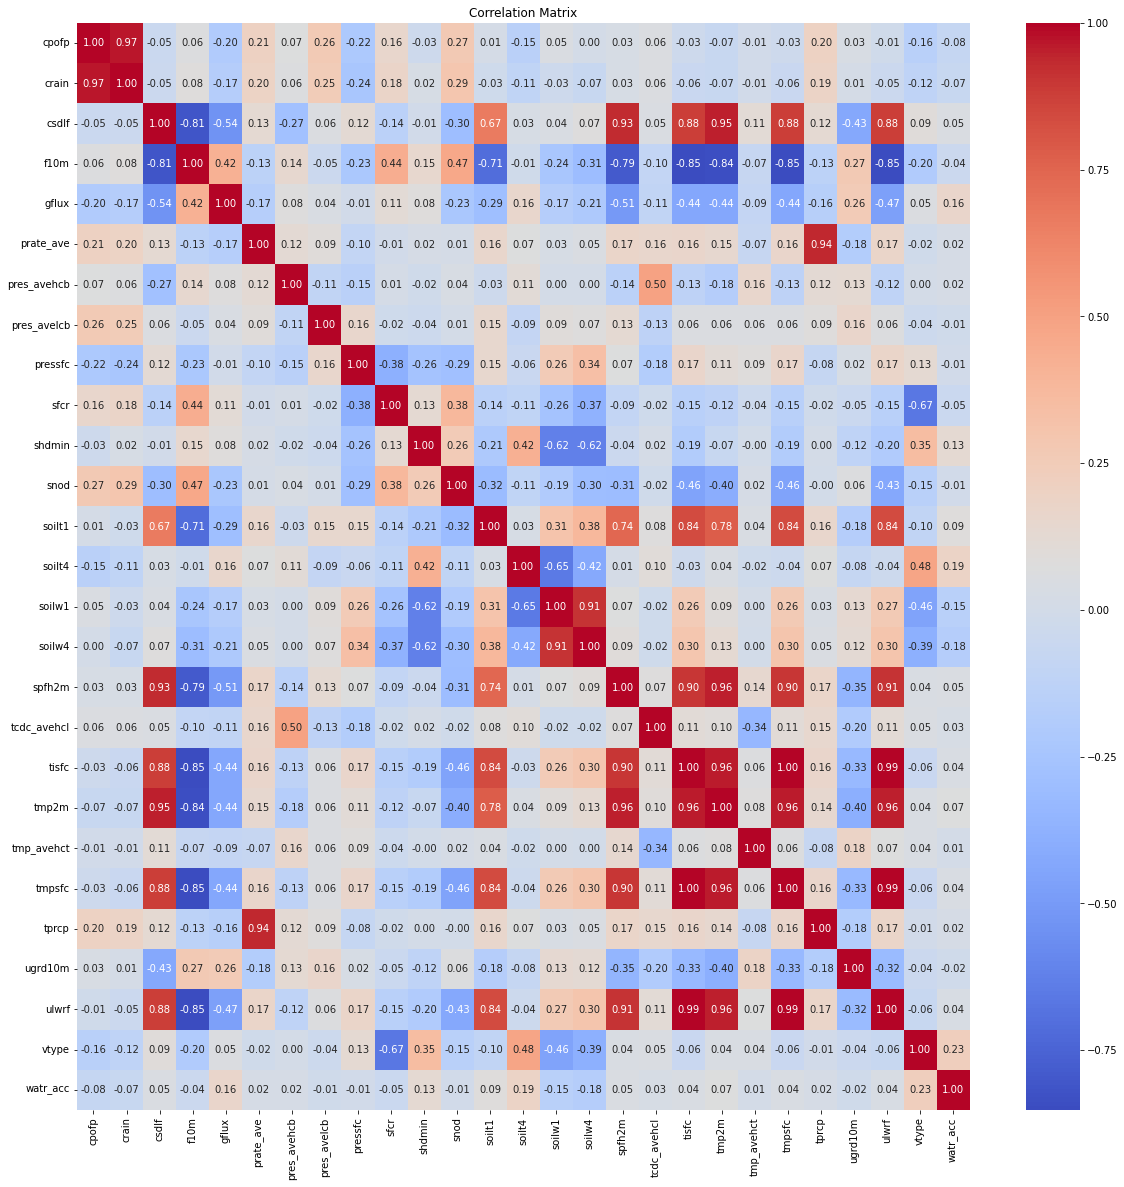

In [0]:
# Display as heatmap
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 20))
sns.heatmap(corr_df, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()

8. What is the weather data for my local town of Avon, MN?

In [0]:
# filter using a lat lon bounding box that should encompass Avon, MN. Had to try a couple ranges to get it right.
avon_df = merged_df.filter(
    ((merged_df.lat >= 45.60) & (merged_df.lat <= 45.63) &
    (merged_df.lon >= 265.54) & (merged_df.lon <= 265.57))
)

avon_df.display()

grid_yt,grid_xt,time,lon,lat,acond,albdo_ave,alnsf,alnwf,alvsf,alvwf,c0,cd,cduvb_ave,cnvprcp,cnwat,cpofp,cprat_ave,cpratb_ave,crain,csdlf,csdsf,csulf,csulftoa,csusf,csusftoa,cwork_aveclm,dconv,dlwrf,dlwrf_ave,dswrf,dswrf_ave,dswrf_avetoa,dtcool,duvb_ave,evbs_ave,evcw_ave,f10m,facsf,facwf,ffhh,ffmm,fldcp,fricv,gflux,gflux_ave,hgt_hyblev1,hpbl,icec,icetk,land,lhtfl,lhtfl_ave,nbdsf_ave,nddsf_ave,orog,pevpr,pevpr_ave,prate_ave,prateb_ave,pres_avehcb,pres_avehct,pres_avelcb,pres_avelct,pres_avemcb,pres_avemct,prescnvclb,prescnvclt,pressfc,pwatclm,qrain,sbsno_ave,sfcr,sfexc,shdmax,shdmin,shtfl,shtfl_ave,sltyp,snoalb,snod,snohf,snowc_ave,soill1,soill2,soill3,soill4,soilm,soilt1,soilt2,soilt3,soilt4,soilw1,soilw2,soilw3,soilw4,sotyp,spfh2m,spfh_hyblev1,spfhmax_max2m,spfhmin_min2m,ssrun_acc,sunsd_acc,tcdc_avebndcl,tcdc_aveclm,tcdc_avehcl,tcdc_avelcl,tcdc_avemcl,tcdccnvcl,tg3,tisfc,tmax_max2m,tmin_min2m,tmp2m,tmp_avehct,tmp_avelct,tmp_avemct,tmp_hyblev1,tmpsfc,tprcp,trans_ave,tref,u-gwd_ave,uflx_ave,ugrd10m,ugrd_hyblev1,ulwrf,ulwrf_ave,ulwrf_avetoa,uswrf,uswrf_ave,uswrf_avetoa,v-gwd_ave,vbdsf_ave,vddsf_ave,veg,vflx_ave,vgrd10m,vgrd_hyblev1,vtype,w0,watr_acc,wd,weasd,wilt,xs,xt,xtts,xu,xv,xz,xzts,zc,date,tmp2m_fahr
45.62967473815922,265.546875,1.0,265.546875,45.62967473815922,0.04804345,0.0,0.2650876,0.25372362,0.09472853,0.091019265,0.0,0.0,0.0,1.5656607E-8,0.41875717,0.0,3.3604397E-8,3.3604397E-8,1.0,204.37265,0.0,291.83612,227.87643,0.0,0.0,0.0,0.0,210.9039,210.92622,0.0,0.0,0.0,0.0,0.0,2.069509,0.24480924,1.0065536,0.94870794,0.05129209,9.459057,3.815688,0.28196698,0.48916575,71.47435,73.34927,9.760523,750.8108,0.0,0.0,1.0,2.6393523,2.3764915,0.0,0.0,360.2355,30.256472,26.751444,3.36057E-8,3.36057E-8,null,null,97547.98,87489.805,null,null,null,null,97653.53,4.664382,0.0,0.0068196864,0.25,0.025174052,0.84893024,0.01,-12.307189,-10.640493,4.0,0.67450213,1.0087673E-5,-1.1199079E-5,0.022520464,0.12758158,0.17266811,0.1589836,0.2271746,421.85202,271.05765,274.0479,277.4377,280.86005,0.32515502,0.22257252,0.1589836,0.2271746,3.0,0.0021117078,0.0021045578,0.0022753705,0.0021117078,0.0,0.0,96.69852,96.69852,0.0,96.41901,0.0,0.0,280.09396,268.7231,269.18866,269.13992,269.16034,null,264.25464,null,269.15942,268.7231,1.5656607E-8,4.553013E-8,279.06256,8.953946E-6,-0.12486525,2.1314638,2.1182234,291.7027,291.93906,227.86597,0.0,0.0,0.0,-3.1062056E-5,0.0,0.0,1.0,0.24272946,-4.322831,-4.2960978,14.0,0.0,0.0058421586,0.0,0.0011643353,0.046958636,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,20240103,24.818610839843792
45.62967473815922,265.546875,1.0,265.546875,45.62967473815922,0.06607533,0.0,0.27396166,0.26224282,0.098191656,0.094215885,0.0,0.0,0.0,0.0,0.39248425,1.0,0.0,0.0,1.0,143.25784,0.0,219.6835,184.24956,0.0,0.0,0.0,0.0,146.30397,146.49867,0.0,0.0,0.0,0.0,0.0,0.013231848,0.0026595213,1.0267876,0.94870794,0.05129209,10.274374,3.726038,0.28196698,0.6619283,53.169586,53.10354,9.06346,529.1159,0.0,0.0,1.0,2.4880025,2.6759453,0.0,0.0,360.2355,2.8572316,3.1039453,4.434758E-7,4.434758E-7,40751.586,34568.887,97013.83,90226.88,64707.56,40751.586,null,null,97594.336,1.7199005,0.0,2.803769,0.25,0.033643976,0.84893024,0.01,-23.332401,-23.658669,4.0,0.67450213,0.117565945,-5.3250126E-4,89.194435,0.099336274,0.11090965,0.1968151,0.23568538,464.14813,262.2099,271.32965,275.7046,279.2582,0.36110368,0.24754441,0.1968151,0.23568538,3.0,4.437076E-4,4.39321E-4,4.4832737E-4,4.437076E-4,0.0,0.0,95.67813,97.54016,5.0,95.711945,38.07378,0.0,280.09396,249.61018,250.33719,250.17595,250.17595,219.22513,248.35574,226.20268,250.20624,249.61018,7.543717E-8,4.1915177E-10,279.06256,6.719021E-5,-0.47040126,5.4179044,5.28211,219.0686,219.36229,184.10043,0.0,0.0,0.0,-6.512229E-5,0.0,0.0,1.0,0.3185949,-3.498691,-3.4111156,14.0,0.0,0.009244158,0.0,10.690874,0.046958636,0.0,0.0,0.0,0.0,0.0,30.0,0.0,0.0,20240114,-9.353291625976524
45.62967473815922,265.546875,1.0,265.546875,45.62967473815922,0.018241199,0.0,0.27019122,0.25864354,0.09654853,0.09265023,0.0,0.0,0.0,0.0,0.39088753,0.0,0.0,0.0,0

In [0]:

# get some aggregated variables for a map read out
avon_agg = avon_df.groupBy("lat","lon").agg(max("snod").alias("max_snow_depth_in_m"),
                                            avg("tmp2m_fahr").alias("average_temp"),
                                            max("tmp2m_fahr").alias("warmest_temp"),
                                            min("tmp2m_fahr").alias("coldest_temp"),
                                            max("ugrd10m").alias("highest_10m_wind"),
                                            max("sfcr").alias("rough_surface")
)

avon_agg.display()

lat,lon,max_snow_depth_in_m,average_temp,warmest_temp,coldest_temp,highest_10m_wind,rough_surface
45.62967473815922,265.546875,0.117565945,14.340753016318086,34.10117919921879,-9.638524169921837,6.462778,0.25


Databricks visualization. Run in Databricks to view.